In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.core.dtypes.common import is_numeric_dtype
from sklearn.feature_selection import mutual_info_regression, f_regression, SelectKBest
from sklearn.preprocessing import MinMaxScaler

In [2]:
DATA_FOLDER = 'dataset'
IMAGE_FOLDER = 'images'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

In [3]:
df = pd.read_csv(DATASET)

categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]

# one hot encoding
df_reg = df.drop(columns=categorical_attr_list)
df_reg = df_reg.join(pd.get_dummies(df[categorical_attr_list], columns=categorical_attr_list).astype(int))

df_reg.head()

,frame_count,sum,mean,std,min,max,q01,q05,q25,q75,...,actor_actor_24,actor_actor_3,actor_actor_4,actor_actor_5,actor_actor_6,actor_actor_7,actor_actor_8,actor_actor_9,sex_F,sex_M
0,158558,0.145081,9.150000e-07,0.004001,-0.038422,0.040588,-0.012586,-0.005890,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
1,160160,0.114319,7.137790e-07,0.004283,-0.042603,0.048157,-0.013550,-0.006104,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
2,156956,0.149963,9.554485e-07,0.005084,-0.037018,0.058472,-0.015822,-0.007294,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1
3,152152,0.139618,9.176213e-07,0.004886,-0.036652,0.062683,-0.014923,-0.006714,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
4,169769,0.137665,8.108948e-07,0.002956,-0.026245,0.026215,-0.009399,-0.004364,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
features_to_correct = ['stft_min', 'sc_min']
(df[features_to_correct] < 0).any()

stft_min    False
sc_min      False
dtype: bool

# stft_min

In [5]:
TARGET = 'stft_min'

# drop quantile columns with high percentage of zeros (20%)
zero_percentage = (df_reg == 0).mean()
to_drop = [col for col in df_reg.columns if zero_percentage[col] > 0.2 and re.search(r'q\d{2}', col)]
to_drop.append('sc_min')
df_reg = df_reg.drop(columns=to_drop)
to_drop

['mfcc_q50',
 'sc_q01',
 'sc_q05',
 'stft_q01',
 'stft_q05',
 'mfcc_q25_w1',
 'mfcc_q50_w1',
 'sc_q05_w1',
 'sc_q25_w1',
 'stft_q05_w1',
 'q50_w2',
 'q50_w3',
 'lag1_q50_w3',
 'q75_w4',
 'sc_min']

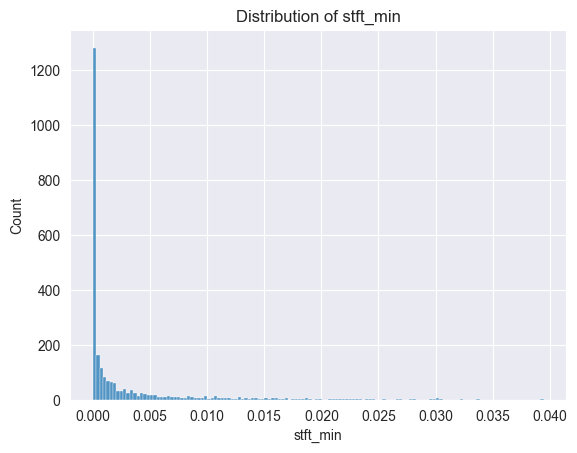

In [6]:
sns.histplot(data=df, x=df[TARGET])
plt.xlabel(f'{TARGET}')
plt.ylabel('Count')
plt.title(f'Distribution of {TARGET}')
plt.savefig(os.path.join(IMAGE_FOLDER, 'initial_stft_min_distr.pdf'), format='pdf')
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

# rows to be fixed, do not reset indexes!
df_zero = df_reg[df_reg[TARGET] == 0]
df_nz = df_reg[df_reg[TARGET] != 0].reset_index(drop=True)

# dataframe has been one hot encoded
split_index = df_nz.index[df_nz['actor_actor_19'] == 1][0]

df_train = df_nz[:split_index]
df_test = df_nz[split_index:]

df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=100)

y_train = np.log10(df_train[TARGET].to_numpy())
y_valid = np.log10(df_valid[TARGET].to_numpy())
y_test = np.log10(df_test[TARGET].to_numpy())

df_zero = df_zero.drop([TARGET], axis=1)
df_train = df_train.drop([TARGET], axis=1)
df_valid = df_valid.drop([TARGET], axis=1)
df_test = df_test.drop([TARGET], axis=1)

X_to_pred = df_zero.to_numpy()
X_train = df_train.to_numpy()
X_valid = df_valid.to_numpy()
X_test = df_test.to_numpy()

print(X_train.shape, X_valid.shape, X_test.shape, X_to_pred.shape)

(847, 269) (212, 269) (361, 269) (1009, 269)


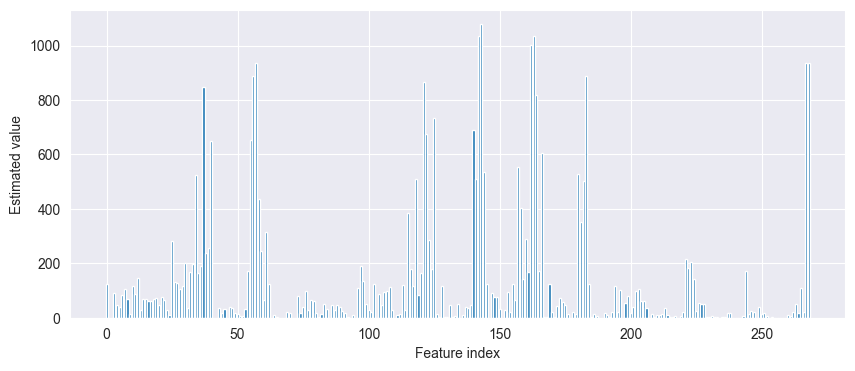

In [8]:
f_selector = SelectKBest(score_func=f_regression, k='all')
f_selector.fit(X_train, y_train)

plt.figure(figsize=(10, 4))
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel('Feature index')
plt.ylabel('Estimated value')
plt.savefig(os.path.join(IMAGE_FOLDER, 'kbest_features_stft_min.pdf'), format='pdf')
plt.show()

In [9]:
f_selector = SelectKBest(score_func=f_regression, k=30)
f_selector.fit(X_train, y_train)

X_train = f_selector.transform(X_train)
X_valid = f_selector.transform(X_valid)
X_test = f_selector.transform(X_test)
X_to_pred = f_selector.transform(X_to_pred)

# selected columns
selected_indices = f_selector.get_support(indices=True)
df_train.iloc[:, selected_indices]

,mfcc_max,mfcc_q25,mfcc_q99,stft_mean,stft_std,stft_q25,stft_q50,stft_skew,mfcc_sum_w2,mfcc_max_w2,...,mfcc_q25_w3,mfcc_q50_w3,mfcc_q75_w3,mfcc_q99_w3,stft_sum_w3,stft_std_w3,stft_q01_w3,stft_q25_w3,sex_F,sex_M
259,176.700997,-18.582673,133.537021,0.391166,0.350493,0.037039,0.326283,0.403797,-73191.432425,199.146823,...,-25.377122,-12.167407,-1.477520,141.949765,264.133460,0.315497,0.000356,0.006469,1,0
157,228.712990,-2.432008,140.389436,0.618064,0.281252,0.400627,0.681809,-0.455598,-42181.134672,230.360681,...,-9.452207,0.308263,9.277478,208.015807,441.161204,0.292768,0.056604,0.228734,0,1
667,203.854065,-10.434671,169.611666,0.499650,0.347630,0.142961,0.526948,0.004334,-42759.290108,202.525541,...,-17.626914,-5.782738,6.776643,182.314767,424.316993,0.316165,0.011171,0.089444,0,1
707,203.586517,-11.989990,140.775630,0.500564,0.321720,0.203172,0.520575,-0.031765,-47750.301556,175.079283,...,-21.128508,-10.204088,2.029520,174.004688,306.164454,0.322009,0.003002,0.052809,1,0
125,182.005960,-6.579166,90.324497,0.475922,0.349201,0.106374,0.504083,0.005237,-33712.577432,137.465293,...,-25.070787,-7.274005,9.855553,124.347880,264.781170,0.324123,0.000231,0.013650,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,210.582387,-10.531611,188.840487,0.448354,0.342674,0.105303,0.398318,0.239043,-52722.125877,222.387541,...,-18.882193,-4.978764,7.866954,207.137736,351.017243,0.308942,0.009667,0.043049,0,1
53,199.024173,-10.841864,159.482310,0.512951,0.316919,0.221845,0.494827,0.110973,-35784.067355,199.100512,...,-18.504748,-4.311820,10.084295,166.648179,425.828800,0.309110,0.014914,0.122665,0,1
350,211.705031,-7.651122,151.113206,0.543641,0.328328,0.233966,0.584822,-0.146795,-32386.011488,191.502232,...,-17.357152,-6.596020,6.551662,192.158127,372.743183,0.318974,0.001936,0.081348,1,0
79,208.686605,-10.683922,143.316089,0.513574,0.286984,0.275286,0.493919,0.168470,-44148.235043,170.792472,...,-16.525048,-5.833418,5.294950,171.602208,483.420806,0.298162,0.033648,0.172040,0,1


In [10]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)
X_to_pred = scaler.fit_transform(X_to_pred)

## XGBoost

In [11]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna

# objective function to be minimized
def objective_fun(trial):

    booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])
    gamma = trial.suggest_float('gamma', 0, 5)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 3)
    subsample = trial.suggest_float('subsample', 0.4, 1)

    xgb = XGBRegressor(booster=booster, gamma=gamma, max_depth=max_depth, min_child_weight=min_child_weight, subsample=subsample)

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_valid)

    error = mean_squared_error(y_valid, y_pred)

    return error


study = optuna.create_study()
study.optimize(objective_fun, n_trials=150, n_jobs=-1)

[I 2023-06-07 16:15:27,987] A new study created in memory with name: no-name-1579e486-80ff-4229-b3fc-d63fb922500a
[I 2023-06-07 16:15:30,146] Trial 3 finished with value: 0.10213318468799094 and parameters: {'booster': 'gbtree', 'gamma': 3.7148525403889505, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.47944757517196324}. Best is trial 3 with value: 0.10213318468799094.
[I 2023-06-07 16:15:31,626] Trial 8 finished with value: 0.09608548457928663 and parameters: {'booster': 'gbtree', 'gamma': 0.970643827299757, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.5310942532416563}. Best is trial 8 with value: 0.09608548457928663.
[I 2023-06-07 16:15:31,664] Trial 6 finished with value: 0.0973052695714564 and parameters: {'booster': 'dart', 'gamma': 2.9344778552179083, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.8907013607662226}. Best is trial 8 with value: 0.09608548457928663.
[I 2023-06-07 16:15:34,076] Trial 4 finished with value: 0.10457549887531557 and parameters

In [12]:
best_params = study.best_params

xgb = XGBRegressor(**best_params)
xgb.fit(X_train, y_train)

y_pred_test = xgb.predict(X_test)

print(best_params)
print('Root mean squared error = %.4f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

{'booster': 'dart', 'gamma': 0.9373247210120965, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.9913929212124503}
Root mean squared error = 0.3740
R-squared = 0.6944


In [13]:
y_pred = xgb.predict(X_to_pred)
y_pred = np.power(10, y_pred)
y_pred

array([0.01473631, 0.01628958, 0.00855803, ..., 0.00017176, 0.00012244,
       0.00010732], dtype=float32)

In [14]:
# negative values predicted
np.count_nonzero(y_pred < 0)

0

In [15]:
df_zero_xgb = df_zero.copy()
df_xgb = df.copy()

df_zero_xgb[TARGET] = y_pred
df_xgb.update(df_zero_xgb)

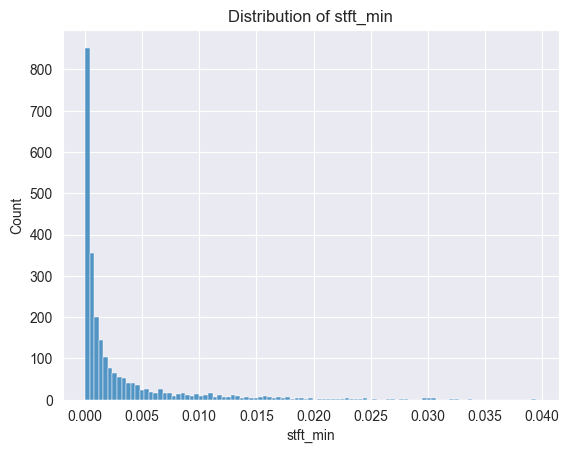

In [16]:
sns.histplot(data=df_xgb, x=TARGET)
plt.xlabel(f'{TARGET}')
plt.ylabel('Count')
plt.title(f'Distribution of {TARGET}')
plt.savefig(os.path.join(IMAGE_FOLDER, 'xgboost_stft_min_distr.pdf'), format='pdf')
plt.show()

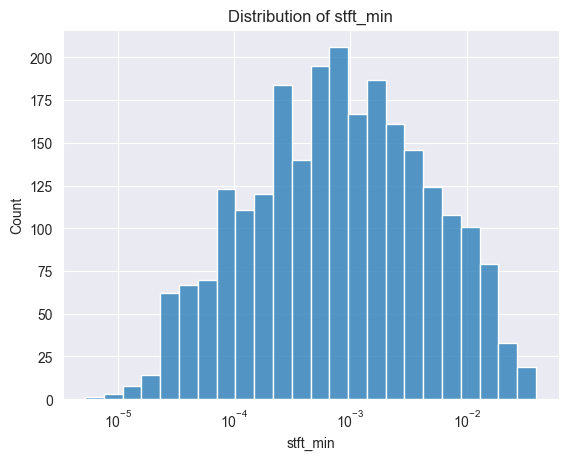

In [17]:
sns.histplot(data=df_xgb, x=TARGET, log_scale=True)
plt.xlabel(f'{TARGET}')
plt.ylabel('Count')
plt.title(f'Distribution of {TARGET}')
plt.savefig(os.path.join(IMAGE_FOLDER, 'xgboost_stft_min_logscale_distr.pdf'), format='pdf')
plt.show()

## Neural Network

In [18]:
import tensorflow
from keras import Sequential
from keras.layers import Dense

def create_model(trial):

    n_hidden = trial.suggest_int('n_hidden', 2, 5)
    n_units = trial.suggest_int('n_units', 32, 128)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1)

    model = Sequential()
    model.add(Dense(n_units, input_dim=X_train.shape[1], activation='relu'))

    for i in range(n_hidden):
        model.add(Dense(n_units, activation='relu'))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
                  optimizer=tensorflow.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                  metrics=tensorflow.keras.metrics.MeanSquaredError())
    return model


# objective function to be minimized
def objective_fun(trial):

    model = create_model(trial)
    model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_valid, y_valid), verbose=False)

    error = model.evaluate(X_valid, y_valid, verbose=False)[1]

    return error


study = optuna.create_study()
study.optimize(objective_fun, n_trials=150, n_jobs=-1)

[I 2023-06-07 16:16:58,405] A new study created in memory with name: no-name-46edd725-5743-44fa-b8ee-0c03ef408aa9
[I 2023-06-07 16:17:01,505] Trial 5 finished with value: 0.1430300921201706 and parameters: {'n_hidden': 4, 'n_units': 33, 'learning_rate': 0.05909478484596726}. Best is trial 5 with value: 0.1430300921201706.
[I 2023-06-07 16:17:01,527] Trial 1 finished with value: 0.5692306160926819 and parameters: {'n_hidden': 3, 'n_units': 61, 'learning_rate': 0.07841310003090272}. Best is trial 5 with value: 0.1430300921201706.
[I 2023-06-07 16:17:01,642] Trial 7 finished with value: 0.5685505270957947 and parameters: {'n_hidden': 2, 'n_units': 102, 'learning_rate': 0.06648674998828037}. Best is trial 5 with value: 0.1430300921201706.
[I 2023-06-07 16:17:01,653] Trial 0 finished with value: 0.5697305798530579 and parameters: {'n_hidden': 4, 'n_units': 46, 'learning_rate': 0.073140329892395}. Best is trial 5 with value: 0.1430300921201706.
[I 2023-06-07 16:17:01,668] Trial 3 finished wi

In [19]:
study.best_params

{'n_hidden': 5, 'n_units': 117, 'learning_rate': 0.0018059779113797341}

In [20]:
model = create_model(study.best_trial)
model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_valid, y_valid), verbose=False)

y_pred_test = model.predict(X_test)

print('Root mean squared error = %.4f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

12/12 [==============================] - 0s 442us/step
Root mean squared error = 0.4043
R-squared = 0.6429


In [21]:
y_pred = model.predict(X_to_pred)
y_pred = np.power(10, y_pred)
y_pred

32/32 [==============================] - 0s 442us/step


array([[1.3794032e-02],
       [1.1083132e-02],
       [9.5537966e-03],
       ...,
       [6.8928217e-05],
       [7.4599346e-05],
       [5.3582029e-05]], dtype=float32)

In [22]:
df_zero_ann = df_zero.copy()
df_ann = df.copy()

df_zero_ann[TARGET] = y_pred
df_ann.update(df_zero_ann)

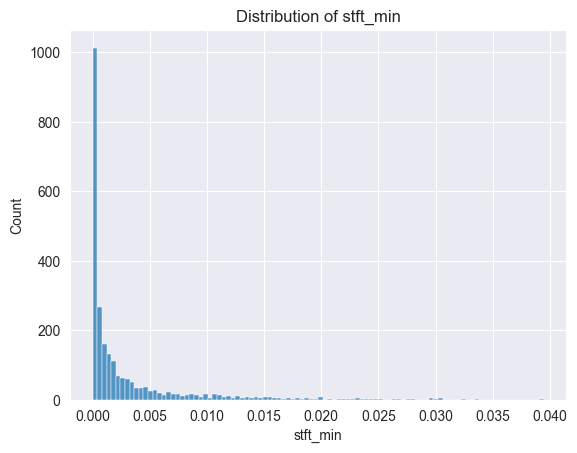

In [23]:
sns.histplot(data=df_ann, x=TARGET)
plt.xlabel(f'{TARGET}')
plt.ylabel('Count')
plt.title(f'Distribution of {TARGET}')
plt.savefig(os.path.join(IMAGE_FOLDER, 'ann_stft_min_distr.pdf'), format='pdf')
plt.show()

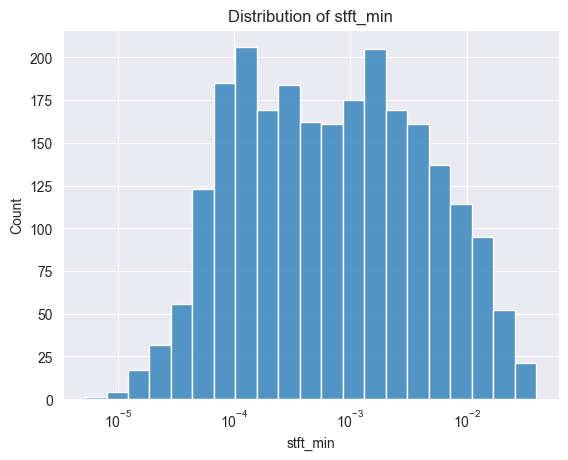

In [24]:
sns.histplot(data=df_ann, x=TARGET, log_scale=True)
plt.xlabel(f'{TARGET}')
plt.ylabel('Count')
plt.title(f'Distribution of {TARGET}')
plt.savefig(os.path.join(IMAGE_FOLDER, 'ann_stft_min_logscale_distr.pdf'), format='pdf')
plt.show()